# **Motorbike Ambulance Calls**
>Motorbike accidents and corresponded ambulance calls are highly depended on environmental and seasonal settings, like weather conditions, precipitation, day of week, season, hour of the day, etc. The data was aggregated over the course of two years, on hourly basis, and then extracted and extended with the corresponding weather and seasonal information.


## **Associated tasks**

---


**Regression**

Prediction of the hourly ambulance calls count based on the environmental and seasonal settings. Prediction model should provide monotonic in the terms of some features, if it is proved by data.

**Event and Anomaly Detection**

Define the  ambulance calls patterns with respect of special events and define the cases that might be considered as abnormal behavior.  

**Deliverables**

Full Texts Report that contains detail description of Data Analysis, Data Modelling and Patterns/Anomaly detection processes with conclusions and their explanations.
What is important here:
* See the **way you’re thinking** – what actions you’re implementing and why
* How **you code** and wrangle the data
* **Storytelling** capabilities – so we’re looking for the full-text structured report separately from the code/notebook
* **Suggestions** on the further  analytics/approaches which could be applied

## **Dataset characteristics:**

---



motorbike_ambulance_calls.csv has the following fields:

              - index: record index
              - date : date
              - season : season (1:springer, 2:summer, 3:fall, 4:winter)
              - yr : year (0: 2011, 1:2012)
              - mnth : month ( 1 to 12)
              - hr : hour (0 to 23)
              - holiday : whether day is holiday or not
              - weekday : day of the week
              - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
              -  weathersit :
                      - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
                      - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                      - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                      - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
              - temp : Normalized temperature in Celsius. The values are divided to 41 (max)
              - atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
              - hum: Normalized humidity. The values are divided to 100 (max)
              - windspeed: Normalized wind speed. The values are divided to 67 (max)
              - cnt: count of total ambulance calls


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor


Завантаження даних та їх обробка

In [2]:
dataset = pd.read_csv('motorbike_ambulance_calls.csv')

dataset['date'] = pd.to_datetime(dataset['date'], errors='coerce')
dataset['day_of_week'] = dataset['date'].dt.dayofweek
dataset['month'] = dataset['date'].dt.month
dataset['year'] = dataset['date'].dt.year


C:\Users\User\AppData\Local\Temp\ipykernel_23316\48522531.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['date'] = pd.to_datetime(dataset['date'], errors='coerce')


для подальшої роботи я розділив дату на детальніші колонки (а саме день тижня місяць та рік). це потрібно для виявлення закономірностей і сезоностей

Візуалізація та аналіз розподілу цільової змінної

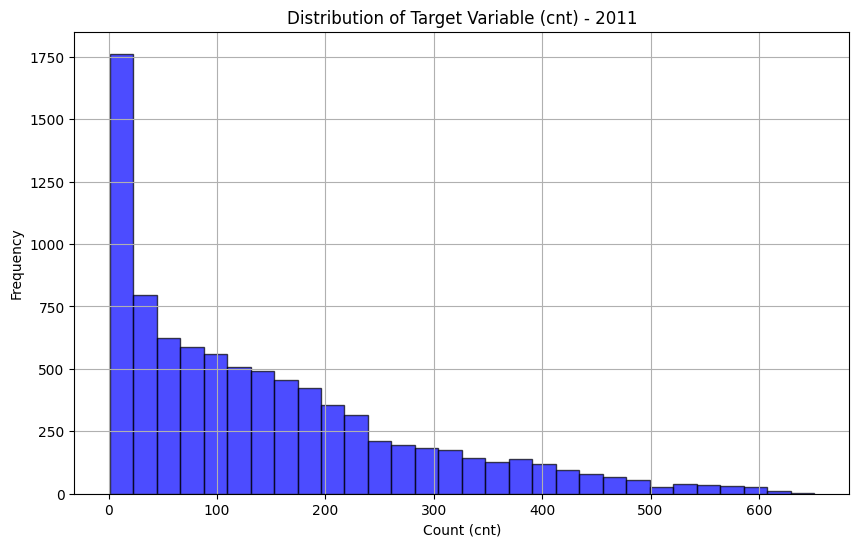

Analysis of Target Variable (cnt) - 2011:
count    8645.000000
mean      143.794448
std       133.797854
min         1.000000
25%        31.000000
50%       109.000000
75%       211.000000
max       651.000000
Name: cnt, dtype: float64


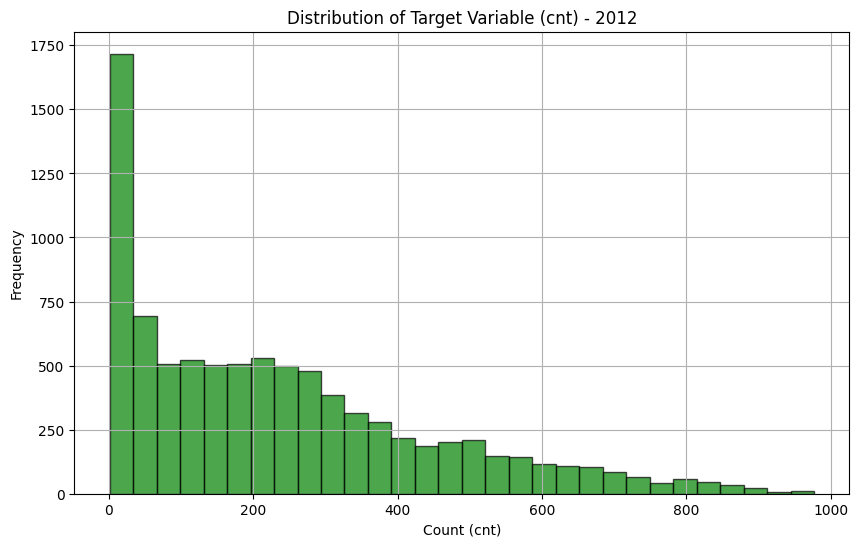

Analysis of Target Variable (cnt) - 2012:
count    8734.000000
mean      234.666361
std       208.910941
min         1.000000
25%        53.000000
50%       191.000000
75%       347.000000
max       977.000000
Name: cnt, dtype: float64


In [13]:
plt.figure(figsize=(10, 6))
dataset[dataset['year'] == 2011]['cnt'].hist(bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Target Variable (cnt) - 2011')
plt.xlabel('Count (cnt)')
plt.ylabel('Frequency')
plt.show()

cnt_stats_2011 = dataset[dataset['year'] == 2011]['cnt'].describe()
print("Analysis of Target Variable (cnt) - 2011:")
print(cnt_stats_2011)

plt.figure(figsize=(10, 6))
dataset[dataset['year'] == 2012]['cnt'].hist(bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribution of Target Variable (cnt) - 2012')
plt.xlabel('Count (cnt)')
plt.ylabel('Frequency')
plt.show()

cnt_stats_2012 = dataset[dataset['year'] == 2012]['cnt'].describe()
print("Analysis of Target Variable (cnt) - 2012:")
print(cnt_stats_2012)


розподіли по рокам візуально досить схожі між собою проте сильно відрізняються по значеням

Попередня обробка даних

In [4]:
X = dataset[['temp', 'hum', 'windspeed', 'holiday', 'weekday', 'workingday', 'weathersit', 'season', 'month', 'hr', 'yr']]
y = dataset['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


categorical_features = ['season', 'weathersit', 'holiday', 'weekday', 'workingday', 'yr']
numeric_features = ['temp', 'hum', 'windspeed', 'month', 'hr']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
])

тут ми розподіляєм дані на категоріальні та числові та обробляжм їх. категоріальні дані ми закодовуєм а числові стандартизовуєм. це потрібно робити щоб покращити роботу моделі.

Random Forest

In [8]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid_rf = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_split': [5, 10]
}

grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_

y_pred_train_rf = best_rf_model.predict(X_train)
y_pred_test_rf = best_rf_model.predict(X_test)

mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)
mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)
mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)
r2_test_rf = r2_score(y_test, y_pred_test_rf)

print(f'Best Parameters (Random Forest): {grid_search_rf.best_params_}')
print(f'Train MSE (Random Forest): {mse_train_rf:.2f}, Test MSE (Random Forest): {mse_test_rf:.2f}')
print(f'Train MAE (Random Forest): {mae_train_rf:.2f}, Test MAE (Random Forest): {mae_test_rf:.2f}')
print(f'Train R² (Random Forest): {r2_train_rf:.2f}, Test R² (Random Forest): {r2_test_rf:.2f}')


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters (Random Forest): {'regressor__max_depth': 20, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
Train MSE (Random Forest): 458.78, Test MSE (Random Forest): 1755.51
Train MAE (Random Forest): 12.82, Test MAE (Random Forest): 24.74
Train R² (Random Forest): 0.99, Test R² (Random Forest): 0.94


XGBoost

In [5]:

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_grid_xgb = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__subsample': [0.8, 1.0]
}


In [6]:
grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

best_xgb_model = grid_search_xgb.best_estimator_


In [7]:

y_pred_train_xgb = best_xgb_model.predict(X_train)
y_pred_test_xgb = best_xgb_model.predict(X_test)

mse_train_xgb = mean_squared_error(y_train, y_pred_train_xgb)
mse_test_xgb = mean_squared_error(y_test, y_pred_test_xgb)
mae_train_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
mae_test_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)
r2_test_xgb = r2_score(y_test, y_pred_test_xgb)

print(f'Best Parameters (XGBoost): {grid_search_xgb.best_params_}')
print(f'Train MSE (XGBoost): {mse_train_xgb:.2f}, Test MSE (XGBoost): {mse_test_xgb:.2f}')
print(f'Train MAE (XGBoost): {mae_train_xgb:.2f}, Test MAE (XGBoost): {mae_test_xgb:.2f}')
print(f'Train R² (XGBoost): {r2_train_xgb:.2f}, Test R² (XGBoost): {r2_test_xgb:.2f}')


Best Parameters (XGBoost): {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}
Train MSE (XGBoost): 1334.04, Test MSE (XGBoost): 1682.21
Train MAE (XGBoost): 23.55, Test MAE (XGBoost): 25.86
Train R² (XGBoost): 0.96, Test R² (XGBoost): 0.95


для обох моделей ми застосували grid search для збільшення точності

порівняння моделей

In [9]:
comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Train MSE': [mse_train_rf, mse_train_xgb],
    'Test MSE': [mse_test_rf, mse_test_xgb],
    'Train MAE': [mae_train_rf, mae_train_xgb],
    'Test MAE': [mae_test_rf, mae_test_xgb],
    'Train R²': [r2_train_rf, r2_train_xgb],
    'Test R²': [r2_test_rf, r2_test_xgb]
})

print(comparison)


           Model    Train MSE     Test MSE  Train MAE   Test MAE  Train R²  \
0  Random Forest   458.778411  1755.508242  12.823176  24.742688  0.986182   
1        XGBoost  1334.037947  1682.212956  23.550242  25.855426  0.959820   

    Test R²  
0  0.944561  
1  0.946875  


обидві моделі гарно впорались проте:
R² та Test MSE практично рівні

Random Forest більш перенавчений ніж XGBoost (судячи з  Train MSE та Test MSE)

проте в цьому випадку в Random Forest трохи точніші прогнози

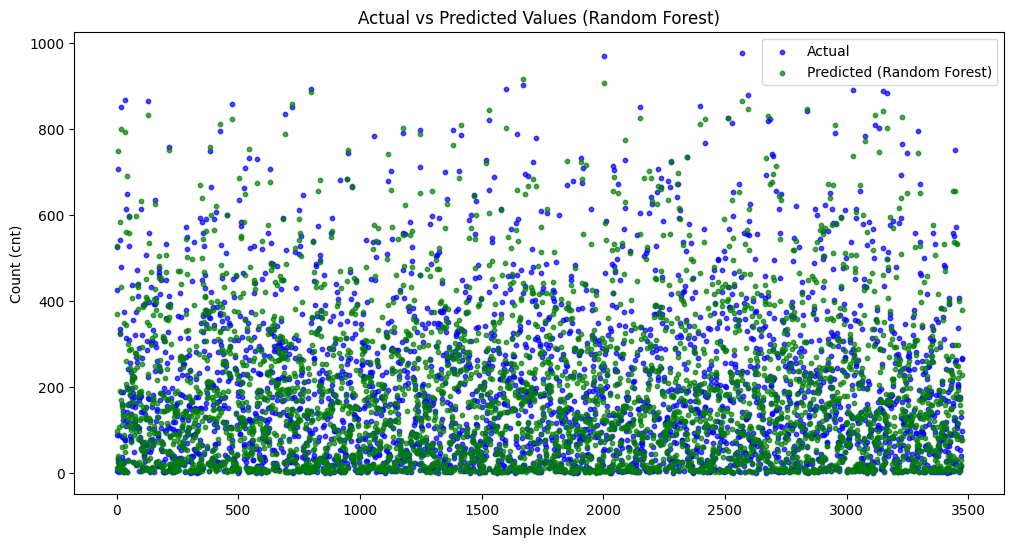

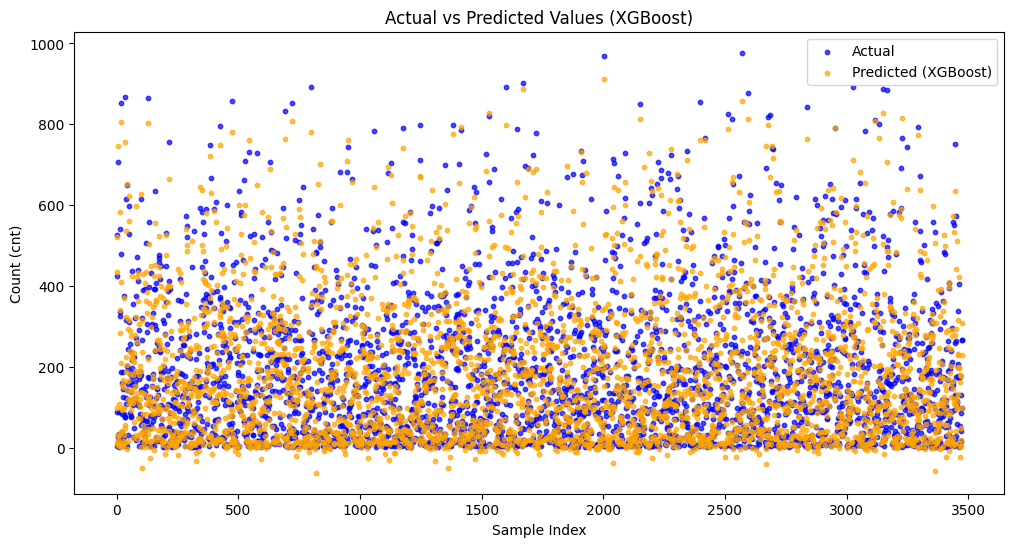

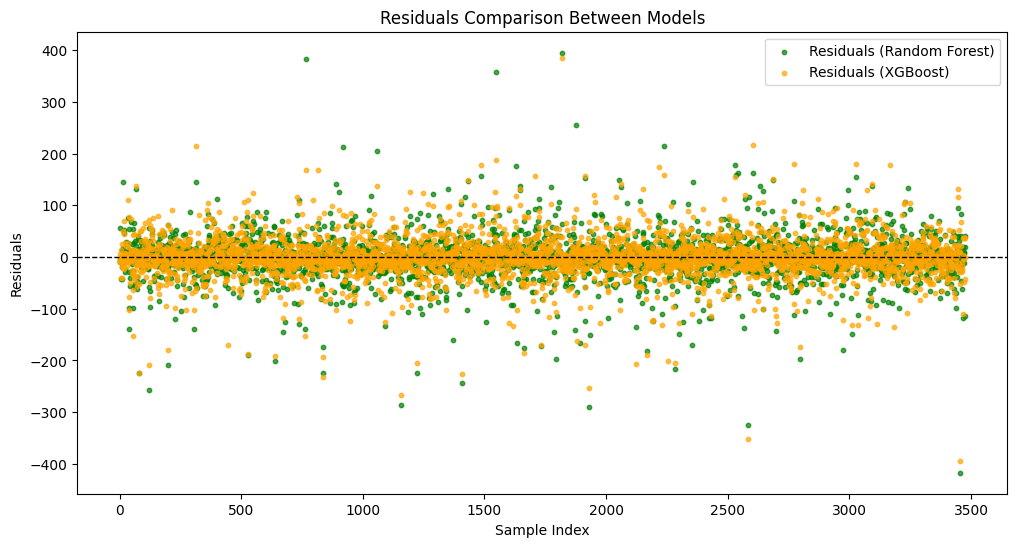

In [12]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual', color='blue', alpha=0.7, s=10)
plt.scatter(range(len(y_test)), y_pred_test_rf, label='Predicted (Random Forest)', color='green', alpha=0.7, s=10)
plt.title('Actual vs Predicted Values (Random Forest)')
plt.xlabel('Sample Index')
plt.ylabel('Count (cnt)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual', color='blue', alpha=0.7, s=10)
plt.scatter(range(len(y_test)), y_pred_test_xgb, label='Predicted (XGBoost)', color='orange', alpha=0.7, s=10)
plt.title('Actual vs Predicted Values (XGBoost)')
plt.xlabel('Sample Index')
plt.ylabel('Count (cnt)')
plt.legend()
plt.show()

residuals_rf = y_test - y_pred_test_rf
residuals_xgb = y_test - y_pred_test_xgb

plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), residuals_rf, alpha=0.7, label='Residuals (Random Forest)', color='green', s=10)
plt.scatter(range(len(y_test)), residuals_xgb, alpha=0.7, label='Residuals (XGBoost)', color='orange', s=10)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Residuals Comparison Between Models')
plt.xlabel('Sample Index')
plt.ylabel('Residuals')
plt.legend()
plt.show()
